# A conditional quantum wasserstein generative adversarial network for learning DIS stock prices

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import plot_model

In [2]:
dataset = np.load('data/dataset.npy', allow_pickle=True)
dis_dataset = dataset[1]

In [3]:
num_latent_qubits = 4
latent_dim = 3 * num_latent_qubits
n_layers = 3
wires = range(len(dis_dataset[0][0][0]) + num_latent_qubits)
weight_shapes = {"weights": (n_layers,len(wires),3)}
dev = qml.device('default.qubit', wires=wires)

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

In [5]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [6]:
x_train, y_train = list(), list()
x_val, y_val = list(), list()
x_test, y_test = list(), list()

for i in range(len(dis_dataset[0])):
    x_train.append(dis_dataset[0][i][0])
    y_train.append(dis_dataset[0][i][1])

for i in range(len(dis_dataset[1])):
    if i <= len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_val.append(dis_dataset[1][i][0])
        y_val.append(dis_dataset[1][i][1])
    
    if i > len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_test.append(dis_dataset[1][i][0])
        y_test.append(dis_dataset[1][i][1])

train_labels, train_y = np.asarray(x_train), np.asarray(y_train)
val_labels, val_y = np.asarray(x_val), np.asarray(y_val)
test_labels, test_y = np.asarray(x_test), np.asarray(y_test)

train_dis_dataset = [train_labels, train_y]
val_dis_dataset = [val_labels, val_y]
test_dis_dataset = [test_labels, test_y]

## Structure of QWGAN

### Discriminator

In [7]:
def define_critic():
    # weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    #` weight constraint
    const = ClipConstraint(0.01)
    
    gen_output = layers.Input(shape=(4,))
    gen_label = layers.Input(shape=(15,))
    merge = layers.Concatenate()([gen_output, gen_label])
    merge = tf.reshape(merge, (-1, 1, 1,19))
    
    x = layers.Conv1D(filters=64, kernel_size=1, kernel_initializer=init, kernel_constraint=const, input_shape=(None, 19))(merge)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv1D(filters=64, kernel_size=1, kernel_initializer=init, kernel_constraint=const)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # linear activation
    x = layers.Flatten()(x)
    Output = layers.Dense(units=1)(x)
    
    # compile model
    model = tf.keras.Model(inputs=[gen_output, gen_label], outputs=Output)
    opt = tf.keras.optimizers.RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [8]:
discriminator = define_critic()

discriminator.summary()

[2021-06-21 00:55:21.896 tensorflow-2-3-cpu-p-ml-m5-4xlarge-b9b58b15c8602c22bc98125af7d7:10403 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-21 00:55:21.947 tensorflow-2-3-cpu-p-ml-m5-4xlarge-b9b58b15c8602c22bc98125af7d7:10403 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
concatenate (Co

### Generator

In [9]:
tf.keras.backend.set_floatx('float64')

In [10]:
@qml.qnode(dev, interface="tf")
def gen_circuit(inputs, weights):
    # Embedding past time series onto circuit (bath)
    qml.templates.AngleEmbedding(inputs[:len(dis_dataset[0][0][0])], wires, rotation='X')
    
    # Gaussian noise through U3 unitaries
    noise_params = tf.reshape(inputs[len(dis_dataset[0][0][0]):], (num_latent_qubits, 3))
    qml.broadcast(unitary=qml.U3, wires=wires[-num_latent_qubits:], pattern="single", parameters=noise_params)
    
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [11]:
def define_generator():    
    # Convert gen_circuit to Keras layer
    b_labels = keras.layers.Input(shape=(15,))
    noise = keras.layers.Input(shape=(num_latent_qubits*3,))
    merged = layers.Concatenate()([b_labels, noise])
    qlayer = qml.qnn.KerasLayer(gen_circuit, weight_shapes, output_dim=len(dis_dataset[0][1][1]), dtype="float64", name='generator_circ')(merged)
    model = tf.keras.models.Model(inputs=[b_labels, noise], outputs=[qlayer])
    return model

In [12]:
# Combined model for updating generator
def define_qgan(generator, critic):
    # set weights of critic to not trainable
    for layer in critic.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # get noise and label inputs from generator model
    gen_label, gen_noise = generator.input
    # get 4 day prediction from the generator model
    g_output = generator.output
    # connect generator output and generator label as inputs into discriminator
    d = critic([g_output, gen_label])
    # define full gan as taking in generator labels and noise to output a discriminator loss
    model = keras.models.Model(inputs=[gen_label, gen_noise], outputs=d)
    
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [13]:
def generate_real_samples(train_labels, train_y, n_samples):
    # choose random instances
    ix = np.random.randint(0, train_y.shape[0], n_samples)
    # select images and labels
    X, labels = train_y[ix], train_labels[ix]
    # generate class labels
    y = -np.ones((n_samples, 1))
    return [X, labels], y

In [14]:
def generate_latent_points(n_samples, train_labels, latent_dim):
    n_classes = train_labels.shape[0]
    # generate points in the latent space
    noise_input = np.random.normal(size=(n_samples, latent_dim))
    # generate labels
    ix = np.random.randint(0, n_classes, n_samples)
    labels = train_labels[ix]
    
    return [noise_input, labels]

In [15]:
def generate_fake_samples(generator, n_samples, latent_dim):
    # generate points in latent space
    noise_input, labels_input = generate_latent_points(n_samples, train_labels, latent_dim)
    # predict outputs
    y_pred = generator.predict([labels_input, noise_input])
    # create class labels
    y = np.ones((n_samples, 1))
    return [y_pred, labels_input], y

In [16]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.close()

In [17]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(dataset[0]) / n_batch)
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            c1_tmp, c2_tmp = list(), list()
            for _ in range(n_critic):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset[0], dataset[1], half_batch)
                # update critic model weights
                c_loss1 = c_model.train_on_batch([X_real, labels_real], y_real)
                c1_tmp.append(c_loss1)
                # generate 'fake' examples
                [X_fake, labels], y_fake = generate_fake_samples(g_model, half_batch, latent_dim)
                # update critic model weights
                c_loss2 = c_model.train_on_batch([X_fake, labels], y_fake)
                c2_tmp.append(c_loss2)     
            # store critic loss
            c1_hist.append(np.mean(c1_tmp))
            c2_hist.append(np.mean(c2_tmp))
            # prepare points in latent space as input for the generator
            [noise_input, train_labels] = generate_latent_points(n_batch, dataset[0], latent_dim)
            # create inverted labels for the fake samples
            y_gan = -np.ones((n_batch, 1))
            # update the generator via the critic's error
            g_loss = gan_model.train_on_batch([train_labels, noise_input], y_gan)
            g_hist.append(g_loss)
            # summarize loss on this batch
            print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)
    return c1_hist, c2_hist, g_hist

In [18]:
# size of the latent space
latent_dim = 4 * 3
# create the critic
critic = define_critic()

In [19]:
# create the generator
generator = define_generator()
# create the gan
qgan_model = define_qgan(generator, critic)

In [20]:
n_batch = 2
n_epochs = 100

# train model
c1_loss, c2_loss, g_loss = train(generator, critic, qgan_model, [train_dis_dataset[0][:n_batch], train_dis_dataset[1][:n_batch]], latent_dim, n_batch=n_batch, n_epochs=n_epochs)

>1, c1=-0.000, c2=0.001 g=-0.124
>2, c1=-0.001, c2=0.002 g=0.110
>3, c1=-0.002, c2=0.002 g=0.028
>4, c1=-0.003, c2=0.003 g=-0.085
>5, c1=-0.003, c2=0.003 g=-0.077
>6, c1=-0.004, c2=0.004 g=0.002
>7, c1=-0.004, c2=0.004 g=0.007
>8, c1=-0.004, c2=0.005 g=-0.038
>9, c1=-0.005, c2=0.005 g=0.102
>10, c1=-0.005, c2=0.006 g=0.031
>11, c1=-0.006, c2=0.006 g=0.003
>12, c1=-0.006, c2=0.006 g=-0.006
>13, c1=-0.006, c2=0.007 g=-0.080
>14, c1=-0.007, c2=0.007 g=-0.075
>15, c1=-0.007, c2=0.007 g=-0.007
>16, c1=-0.007, c2=0.008 g=0.063
>17, c1=-0.008, c2=0.008 g=-0.014
>18, c1=-0.008, c2=0.008 g=0.130
>19, c1=-0.008, c2=0.009 g=-0.025
>20, c1=-0.009, c2=0.009 g=-0.033
>21, c1=-0.009, c2=0.009 g=-0.034
>22, c1=-0.009, c2=0.010 g=0.081
>23, c1=-0.010, c2=0.010 g=-0.078
>24, c1=-0.010, c2=0.010 g=-0.000
>25, c1=-0.010, c2=0.011 g=-0.033
>26, c1=-0.011, c2=0.011 g=-0.021
>27, c1=-0.011, c2=0.011 g=-0.060
>28, c1=-0.011, c2=0.012 g=-0.041
>29, c1=-0.012, c2=0.012 g=-0.038
>30, c1=-0.012, c2=0.012 g=-0.039

### Visualizing the training process

In [21]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

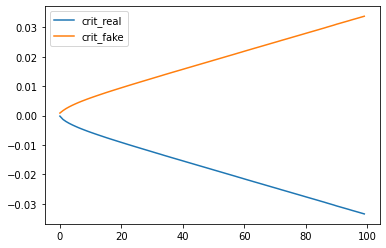

In [22]:
plt.plot(c1_loss, label='crit_real')
plt.plot(c2_loss, label='crit_fake')
plt.legend()
plt.show()

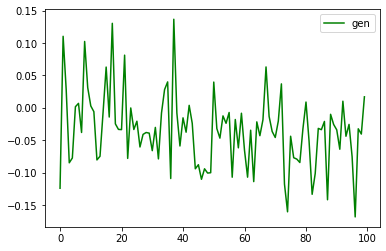

In [23]:
plt.plot(g_loss, label='gen', color='green')
plt.legend()
plt.show()

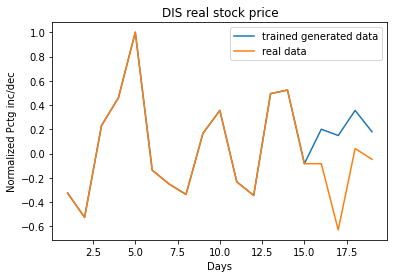

Accuracy: 0.91558687960044


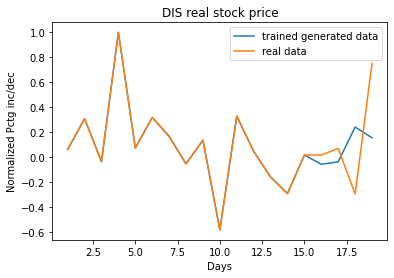

Accuracy: 0.9307809384975808


In [25]:
for i in range(n_batch):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(train_dis_dataset[0][i], train_dis_dataset[1][i])
    fake_stats = tf.reshape(tf.concat([np.reshape(train_dis_dataset[0][i], (1,15)), generator.predict([np.reshape(train_dis_dataset[0][i], (1,15)), np.random.normal(size=(1,12))])], 1), (19,)).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()
    
    print(f"Accuracy: {accuracy(real_stats, fake_stats)}")

<hr>